## what we're covering  
- 1: data (prepare and load)
- 2: build model
- 3: fitting the model to data (training)
- 4: making predictions and evaluating a model (inference)
- 5: saving and loading a model
- 6: putting it all together
  
[Book chapter link](https://www.learnpytorch.io/01_pytorch_workflow/)


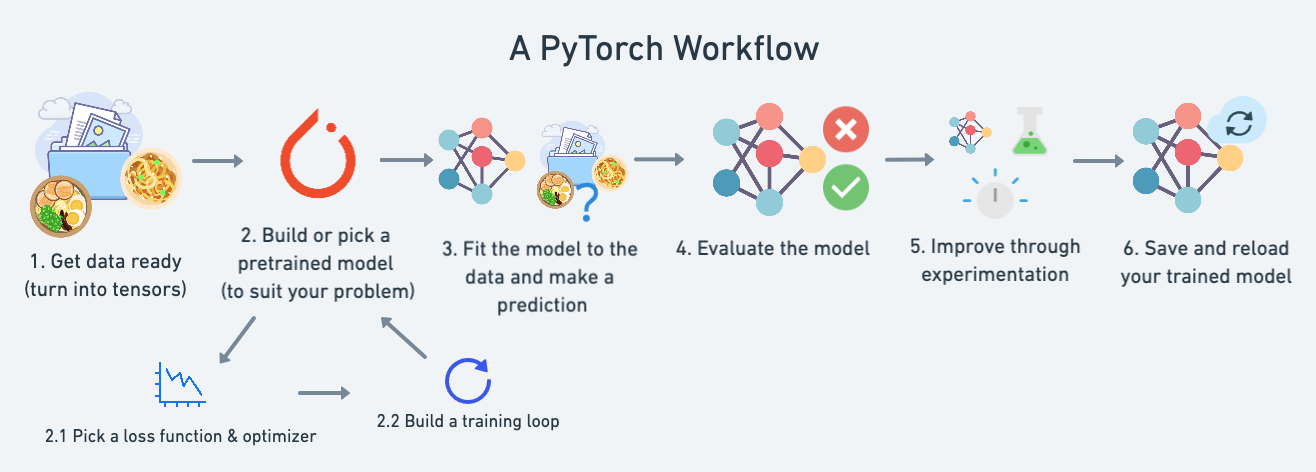

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cpu'

## 1. Data (preparing and loading)

**Machine learning is a game of two parts:**

1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

We'll use **linear regression** to create the data with *known* **parameters** (things that can be learned by a model) \
and then we'll use PyTorch to see if we can **build mode**l to estimate these parameters using **gradient descent**.

In [2]:
# Create *Known* parameters
weight = 0.7 # for our example = the slope
bias = 0.3 # the y intercept

# Create input and output data
start = 0
end = 1
step = 0.02

# Input data (remember: matrices are capital letters)
X = torch.arange(start, end, step).unsqueeze(dim=1)

# Output data (ideal output and our model should try to get outputs like this one)
y = weight * X + bias

print(f"First 10 elements of INPUT:\n{X[:10]}\n")
print(f"First 10 elements of OUTPUT:\n{y[:10]}")

First 10 elements of INPUT:
tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

First 10 elements of OUTPUT:
tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


**Split data into training and test sets**
- Training set ~60-80% (Always)
- Validation set ~10-20% (Often but not always)
- Testing set ~10-20% (Always)

In [3]:
print(f"Total input set = {len(X)}")
print(f"Total output set = {len(y)}")

train_set = int(0.8*len(X)) # Train split
x_train = X[:train_set] # Train with 80%
y_train = y[:train_set]

x_test = X[train_set:] # Test with the other 20%
y_test = y[train_set:] 

print(f"train set length for x = {len(x_train)} and y = {len(y_train)}")
print(f"test set length for x = {len(x_test)} and y = {len(y_test)}")


Total input set = 50
Total output set = 50
train set length for x = 40 and y = 40
test set length for x = 10 and y = 10


In [4]:
def plot_predictions(train_data = x_train, #i/p train
                     tarin_lables = y_train, #o/p train
                     test_data = x_test,
                     test_labels = y_test,
                     predictions = None
                     ):
    """
    Plots training data,
    test data 
    and compares predictions.
    """
    
    plt.figure(figsize=(10,7))
    
    # Plot training data in blue ('c for color, 's for size)
    plt.scatter(train_data, tarin_lables, c='b', s=4, label="Training data")
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=15, label="Testing data")
    
    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=15, label="Predictions")

    # Show the legend (lables in a box at the corner)
    plt.legend(prop={"size": 14});

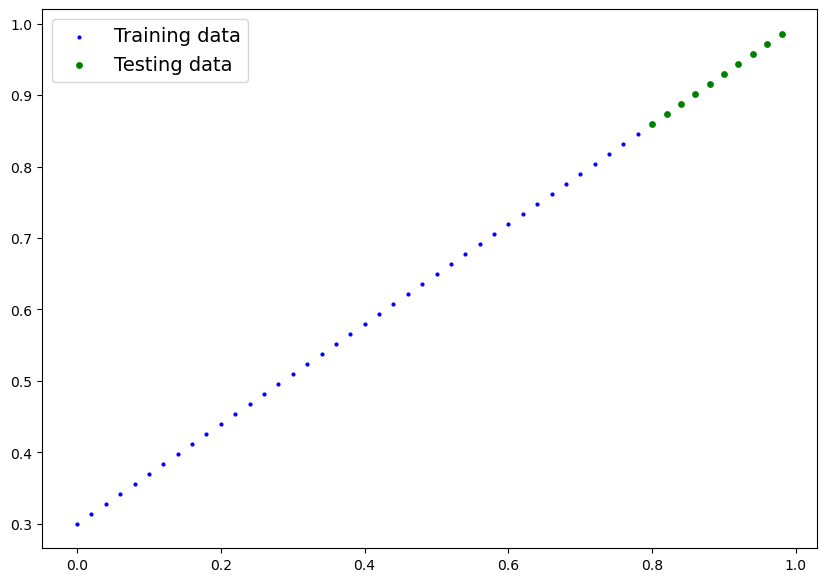

In [5]:
plot_predictions()

## 2. Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(
                                    torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?

        self.bias = nn.Parameter(
                                torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?

    # Forward defines the computation in the model (the equations used)
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
        # Ideally this should return wieght = 0.7 and bias = 0.3

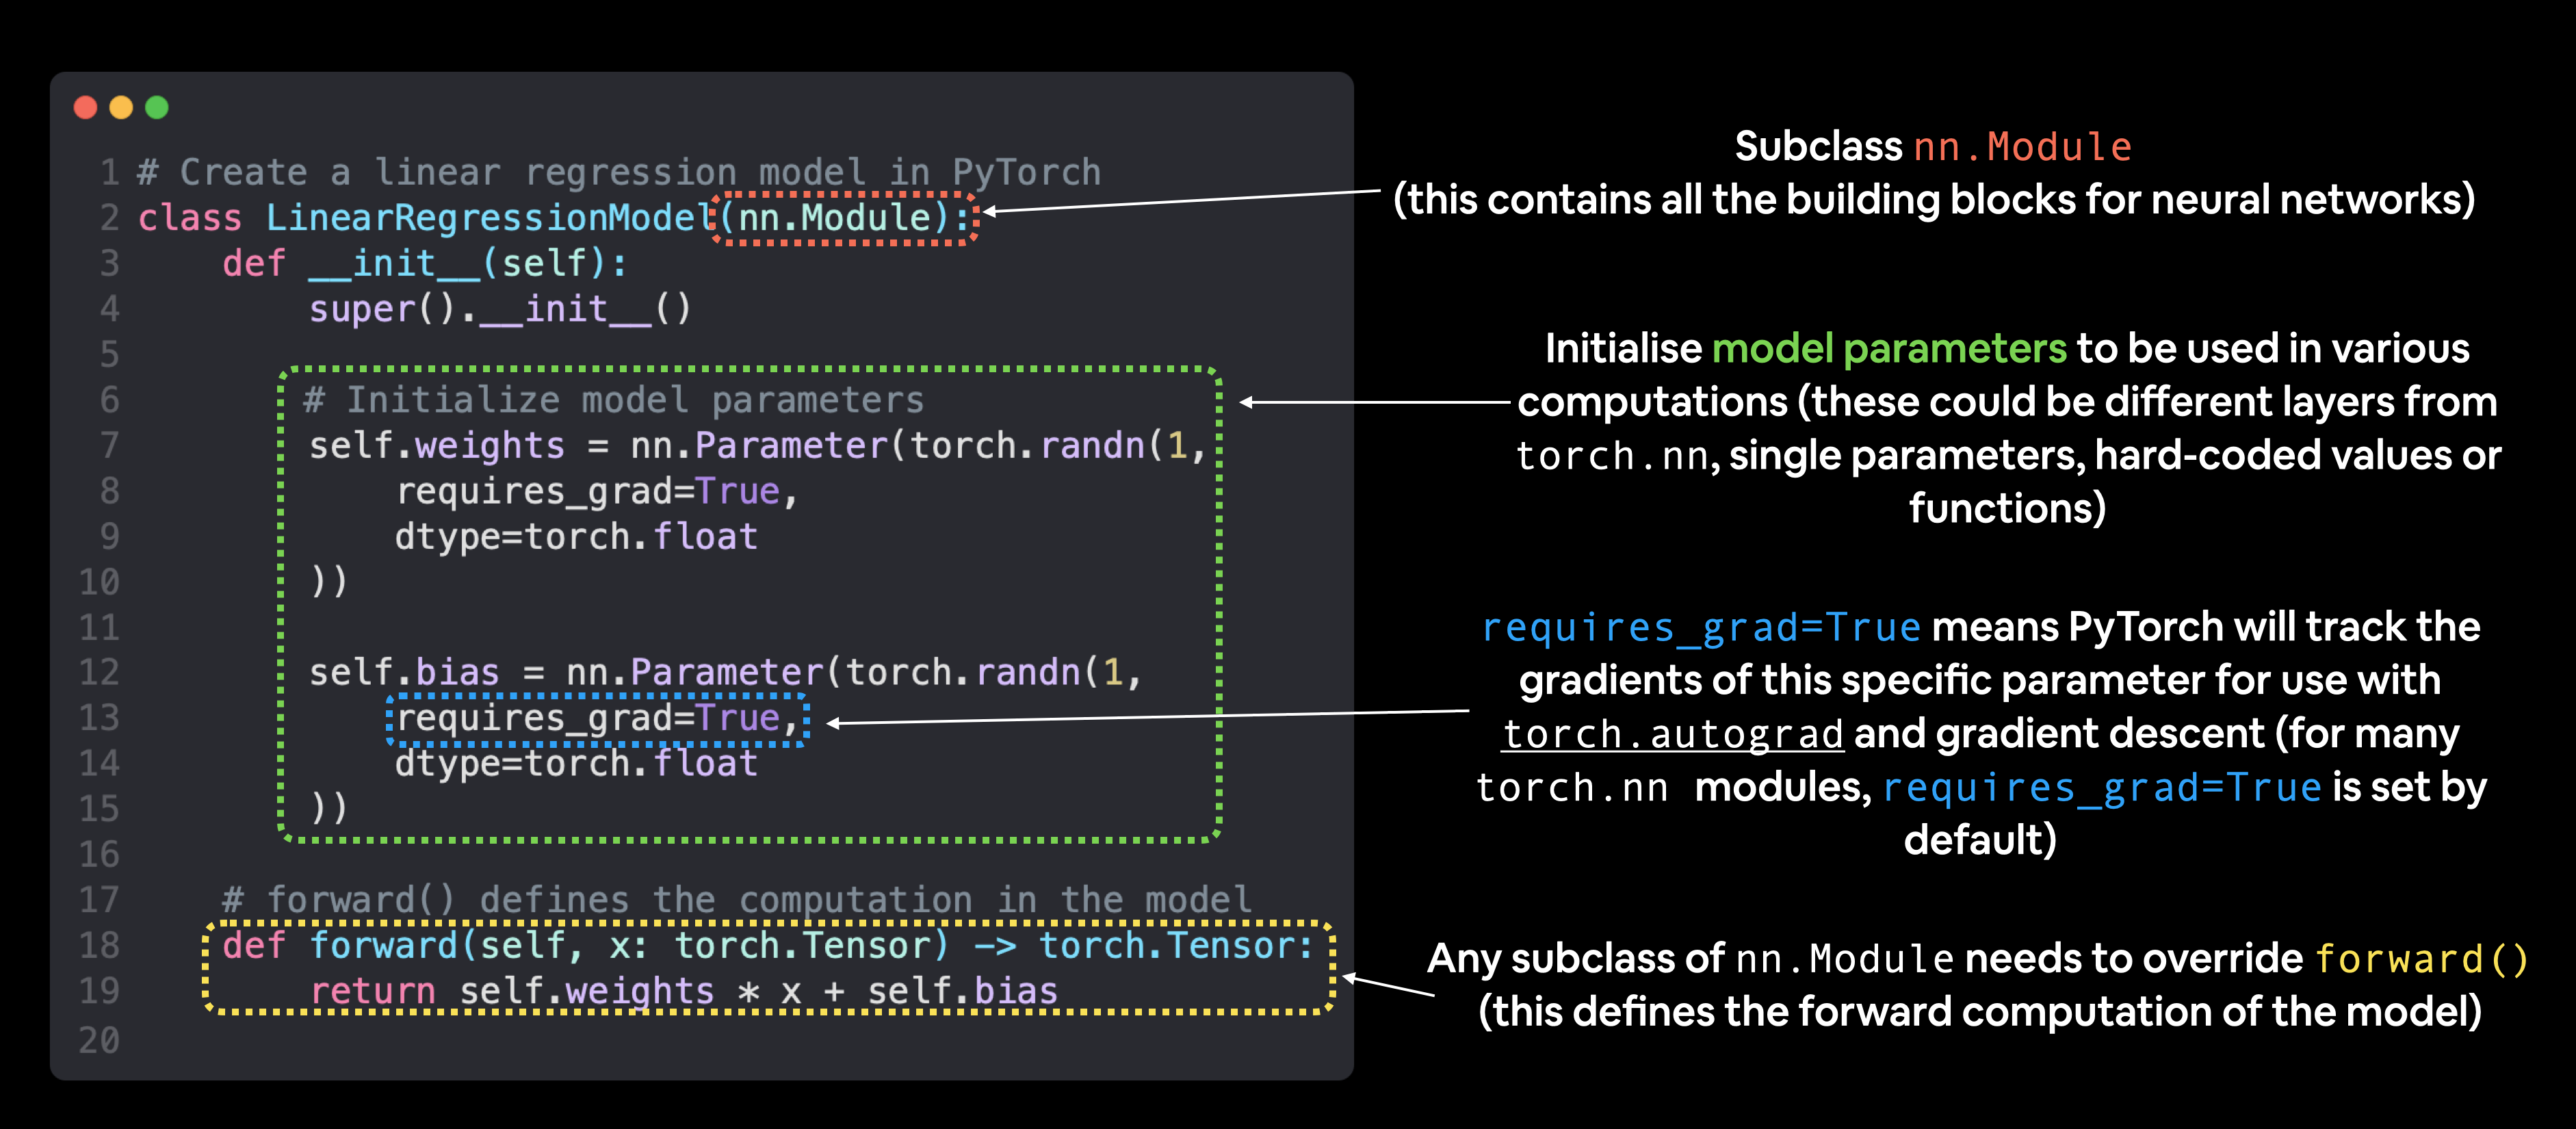
See more of these essential modules and their use cases in the [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html).

### PyTorch model building essentials:
- `nn.Module`: contains the larger building blocks (layers)
- `nn.Parameter`: contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
- `forward()`: tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
- `torch.optim`: contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

### Checking the contents of a PyTorch model

In [7]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# We can also get the state (what the model contains) of the model using .state_dict()
# List named parameters 
model_0.state_dict() #state dictionary

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


Notice how the values for `weights` and `bias` from `model_0.state_dict()` come out as random float tensors?

This is because we initialized them above using `torch.randn()`.

Essentially we want to **start** from **random parameters** and get the model to **update** them towards **parameters that fit our data best** (the hardcoded weight and bias values we set when creating our straight line data).

### Making predictions using `torch.inference_mode()`

`torch.inference_mode()` turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make **forward-passes** (data going through the forward() method) faster.

Note: In older PyTorch code, you may also see `torch.no_grad()` being used for inference. While `torch.inference_mode()` and `torch.no_grad()` do similar things, `torch.inference_mode()` is **newer**, potentially faster and preferred.\
\
[See this Tweet from PyTorch for more.](https://x.com/PyTorch/status/1437838231505096708)

In [9]:
# Make predictions with model (with no grad for faster compu)
with torch.inference_mode(): 
    y_preds = model_0(x_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [10]:
# Check the predictions
print(f"Number of testing samples: {len(x_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}\n")
print(f"Actuall value: \n{y_test}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

Actuall value: 
tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])


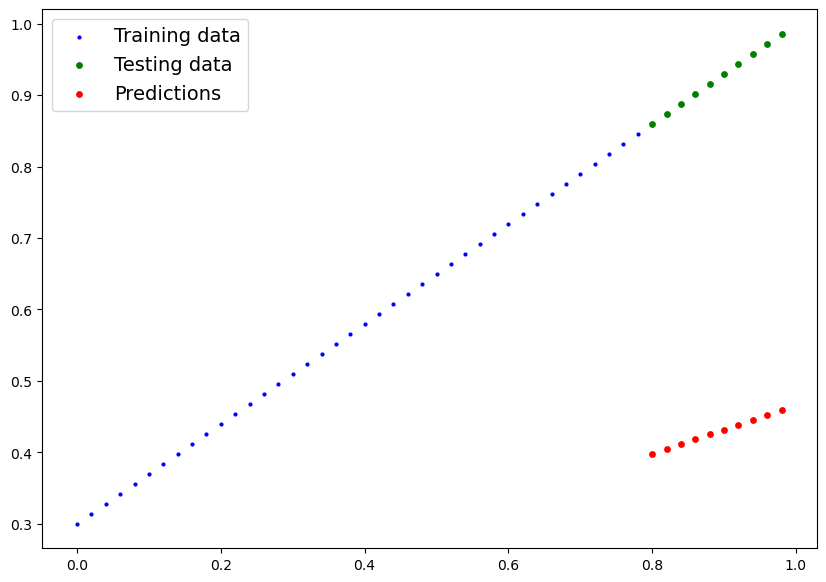

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
print(f"Error = \n{y_test - y_preds}")

Error = 
tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])


Those predictions look pretty bad...

This makes sense though, when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

### Creating a loss (cost) function and optimizer in PyTorch
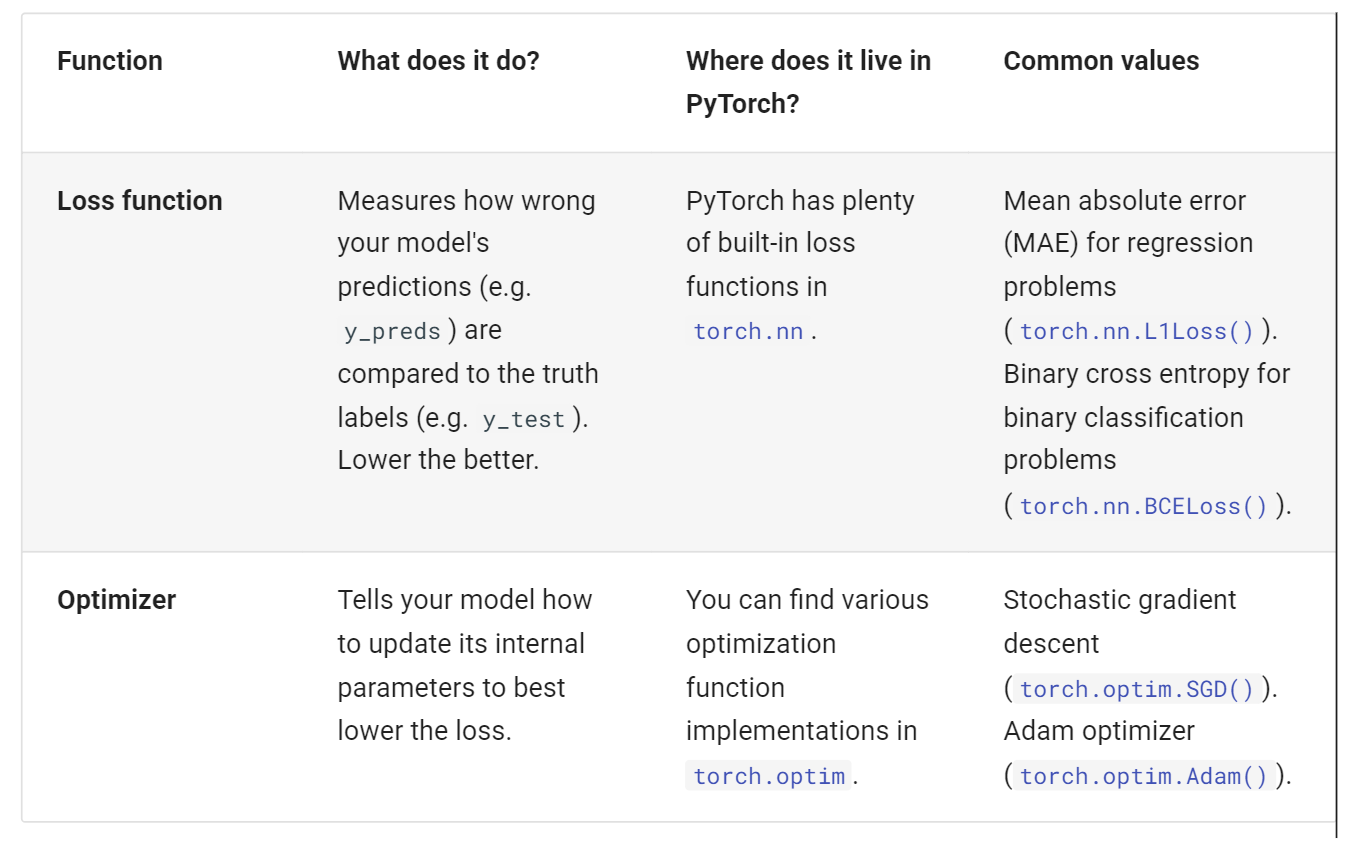

For our problem, since we're predicting a number, let's use **MAE** (which is under `torch.nn.L1Loss()`) in PyTorch as our **loss function**.\
MAE measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.

And we'll use **SGD**, `torch.optim.SGD(params, lr)` where:

- `params` is the *target model parameters* you'd like to optimize (e.g. the weights and bias values we randomly set before).
- `lr` is the *learning rate* you'd like the optimizer to *update* the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values).\
The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).

In [13]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, 
                                    # higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch
- **The training loop** involves the model going through the *training data* and learning the relationships between the `features` and `labels`.
- **The testing loop** involves going through the *testing data* and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

### PyTorch training loop
For the training loop, we'll build the following steps:
1. **model.tarin()**: tells the model we want to go to training mode.
1. **Forward pass**: The model goes through all of the training data once, performing its `forward()` function calculations.
2. **Calculate the loss**: The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are.
3. **Zero gradients**: The optimizers gradients are set to **zero** (they are accumulated by default) so they can be recalculated for the specific training step.
4. **Perform backpropagation on the loss**: Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".
5. **Update the optimizer (gradient descent)**: Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them.

- [Gradient descent explained](https://www.youtube.com/watch?v=IHZwWFHWa-w)
- [Backpropagation explained (very very very recommended)](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

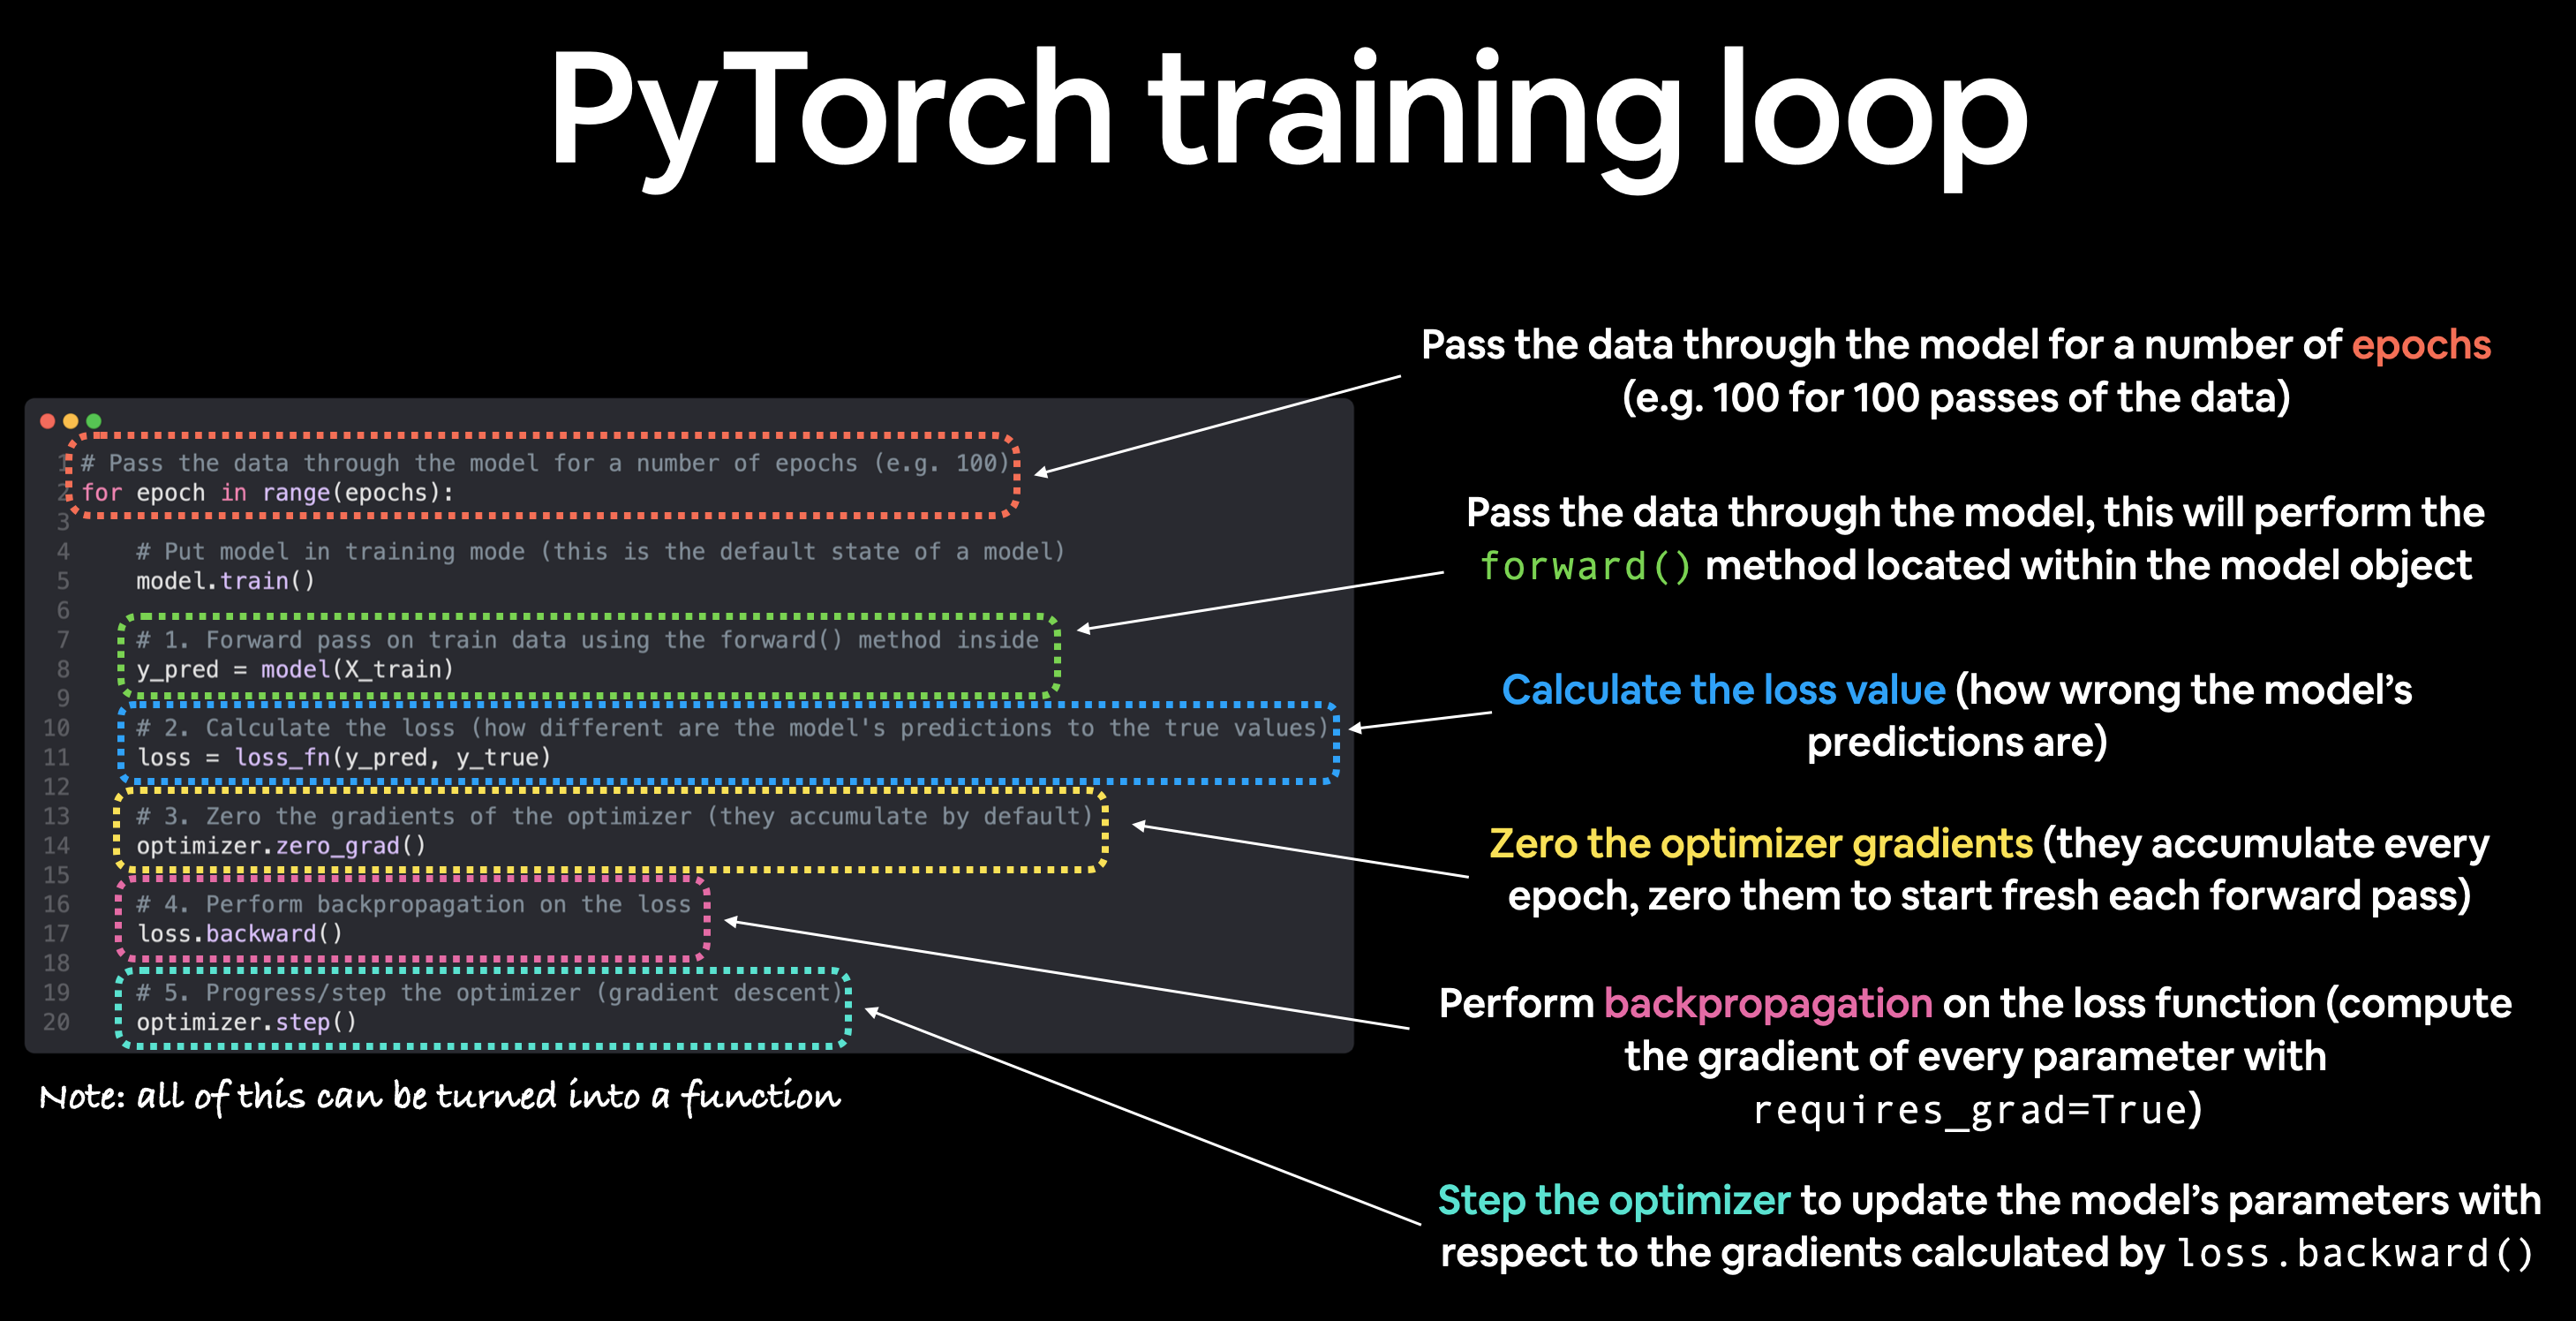
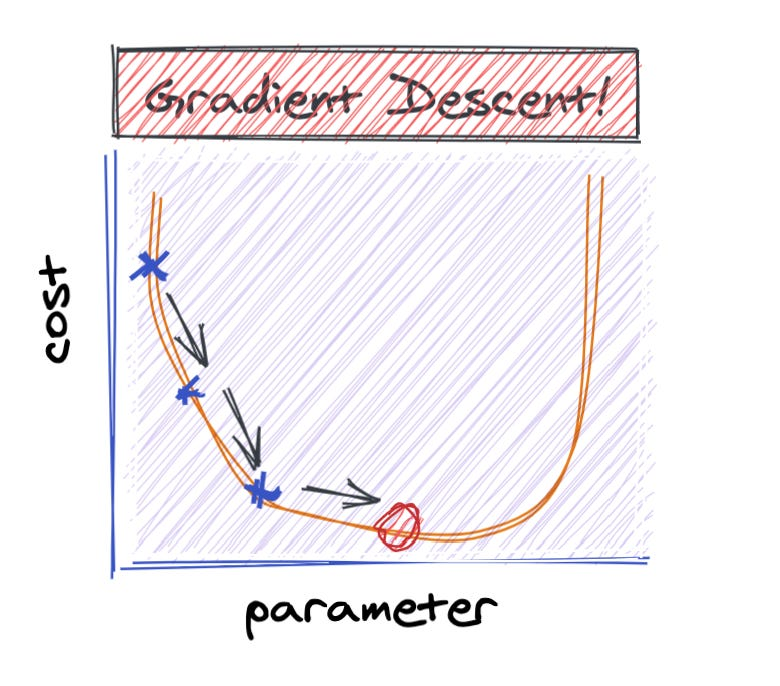
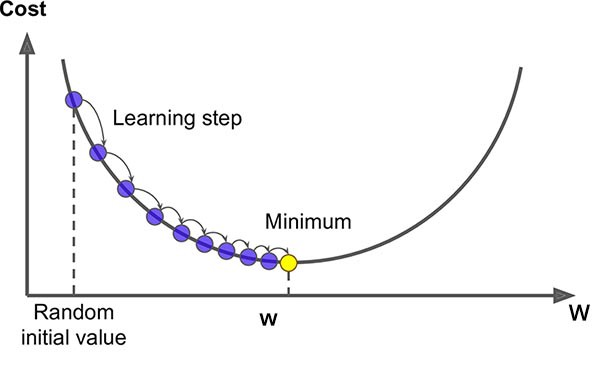 


In [14]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 10

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(x_train)
    if (epoch%2 == 0): # Test print after each and every other epoch
        print(model_0.state_dict())

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    if (epoch%2 == 0): # Test print after each and every other epoch
        print(loss)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    # Put the model in evaluation mode
    model_0.eval()


OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})
tensor(0.3129, grad_fn=<MeanBackward0>)
OrderedDict({'weights': tensor([0.3445]), 'bias': tensor([0.1488])})
tensor(0.2898, grad_fn=<MeanBackward0>)
OrderedDict({'weights': tensor([0.3523]), 'bias': tensor([0.1688])})
tensor(0.2668, grad_fn=<MeanBackward0>)
OrderedDict({'weights': tensor([0.3601]), 'bias': tensor([0.1888])})
tensor(0.2438, grad_fn=<MeanBackward0>)
OrderedDict({'weights': tensor([0.3679]), 'bias': tensor([0.2088])})
tensor(0.2207, grad_fn=<MeanBackward0>)


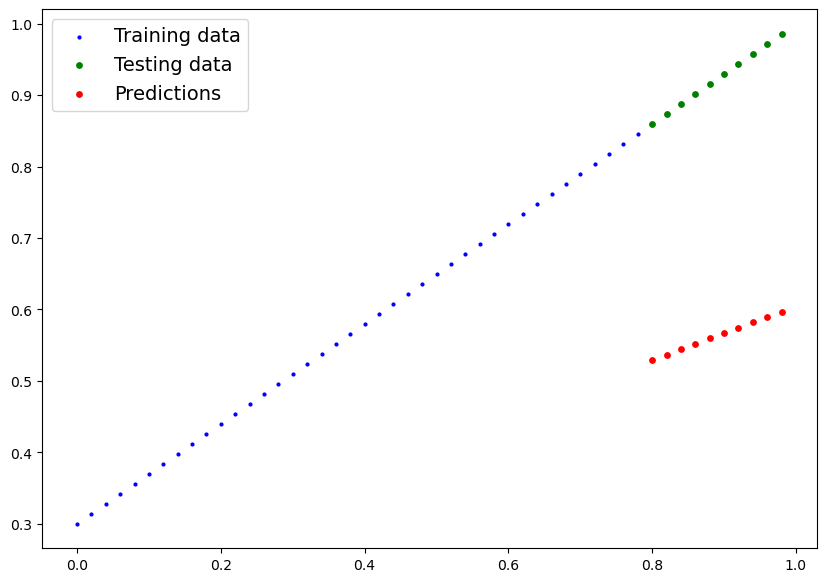

In [15]:
# Now predect again after training our model
with torch.inference_mode():
    y_preds = model_0(x_test)
    
# Plot it and notice how the red dots became closer to the green ones
plot_predictions(predictions=y_preds)

### PyTorch testing loop
For the testing loop, we'll build the following steps:
1. **model.eval()**: tells the model we want to *evaluate* rather than train.
2. **Forward pass**: this time we pass the `testing inputs` not the training ones.
3. **Calculate the loss**: pass the `test predections` and the `actual answers` to see how wrong we are.

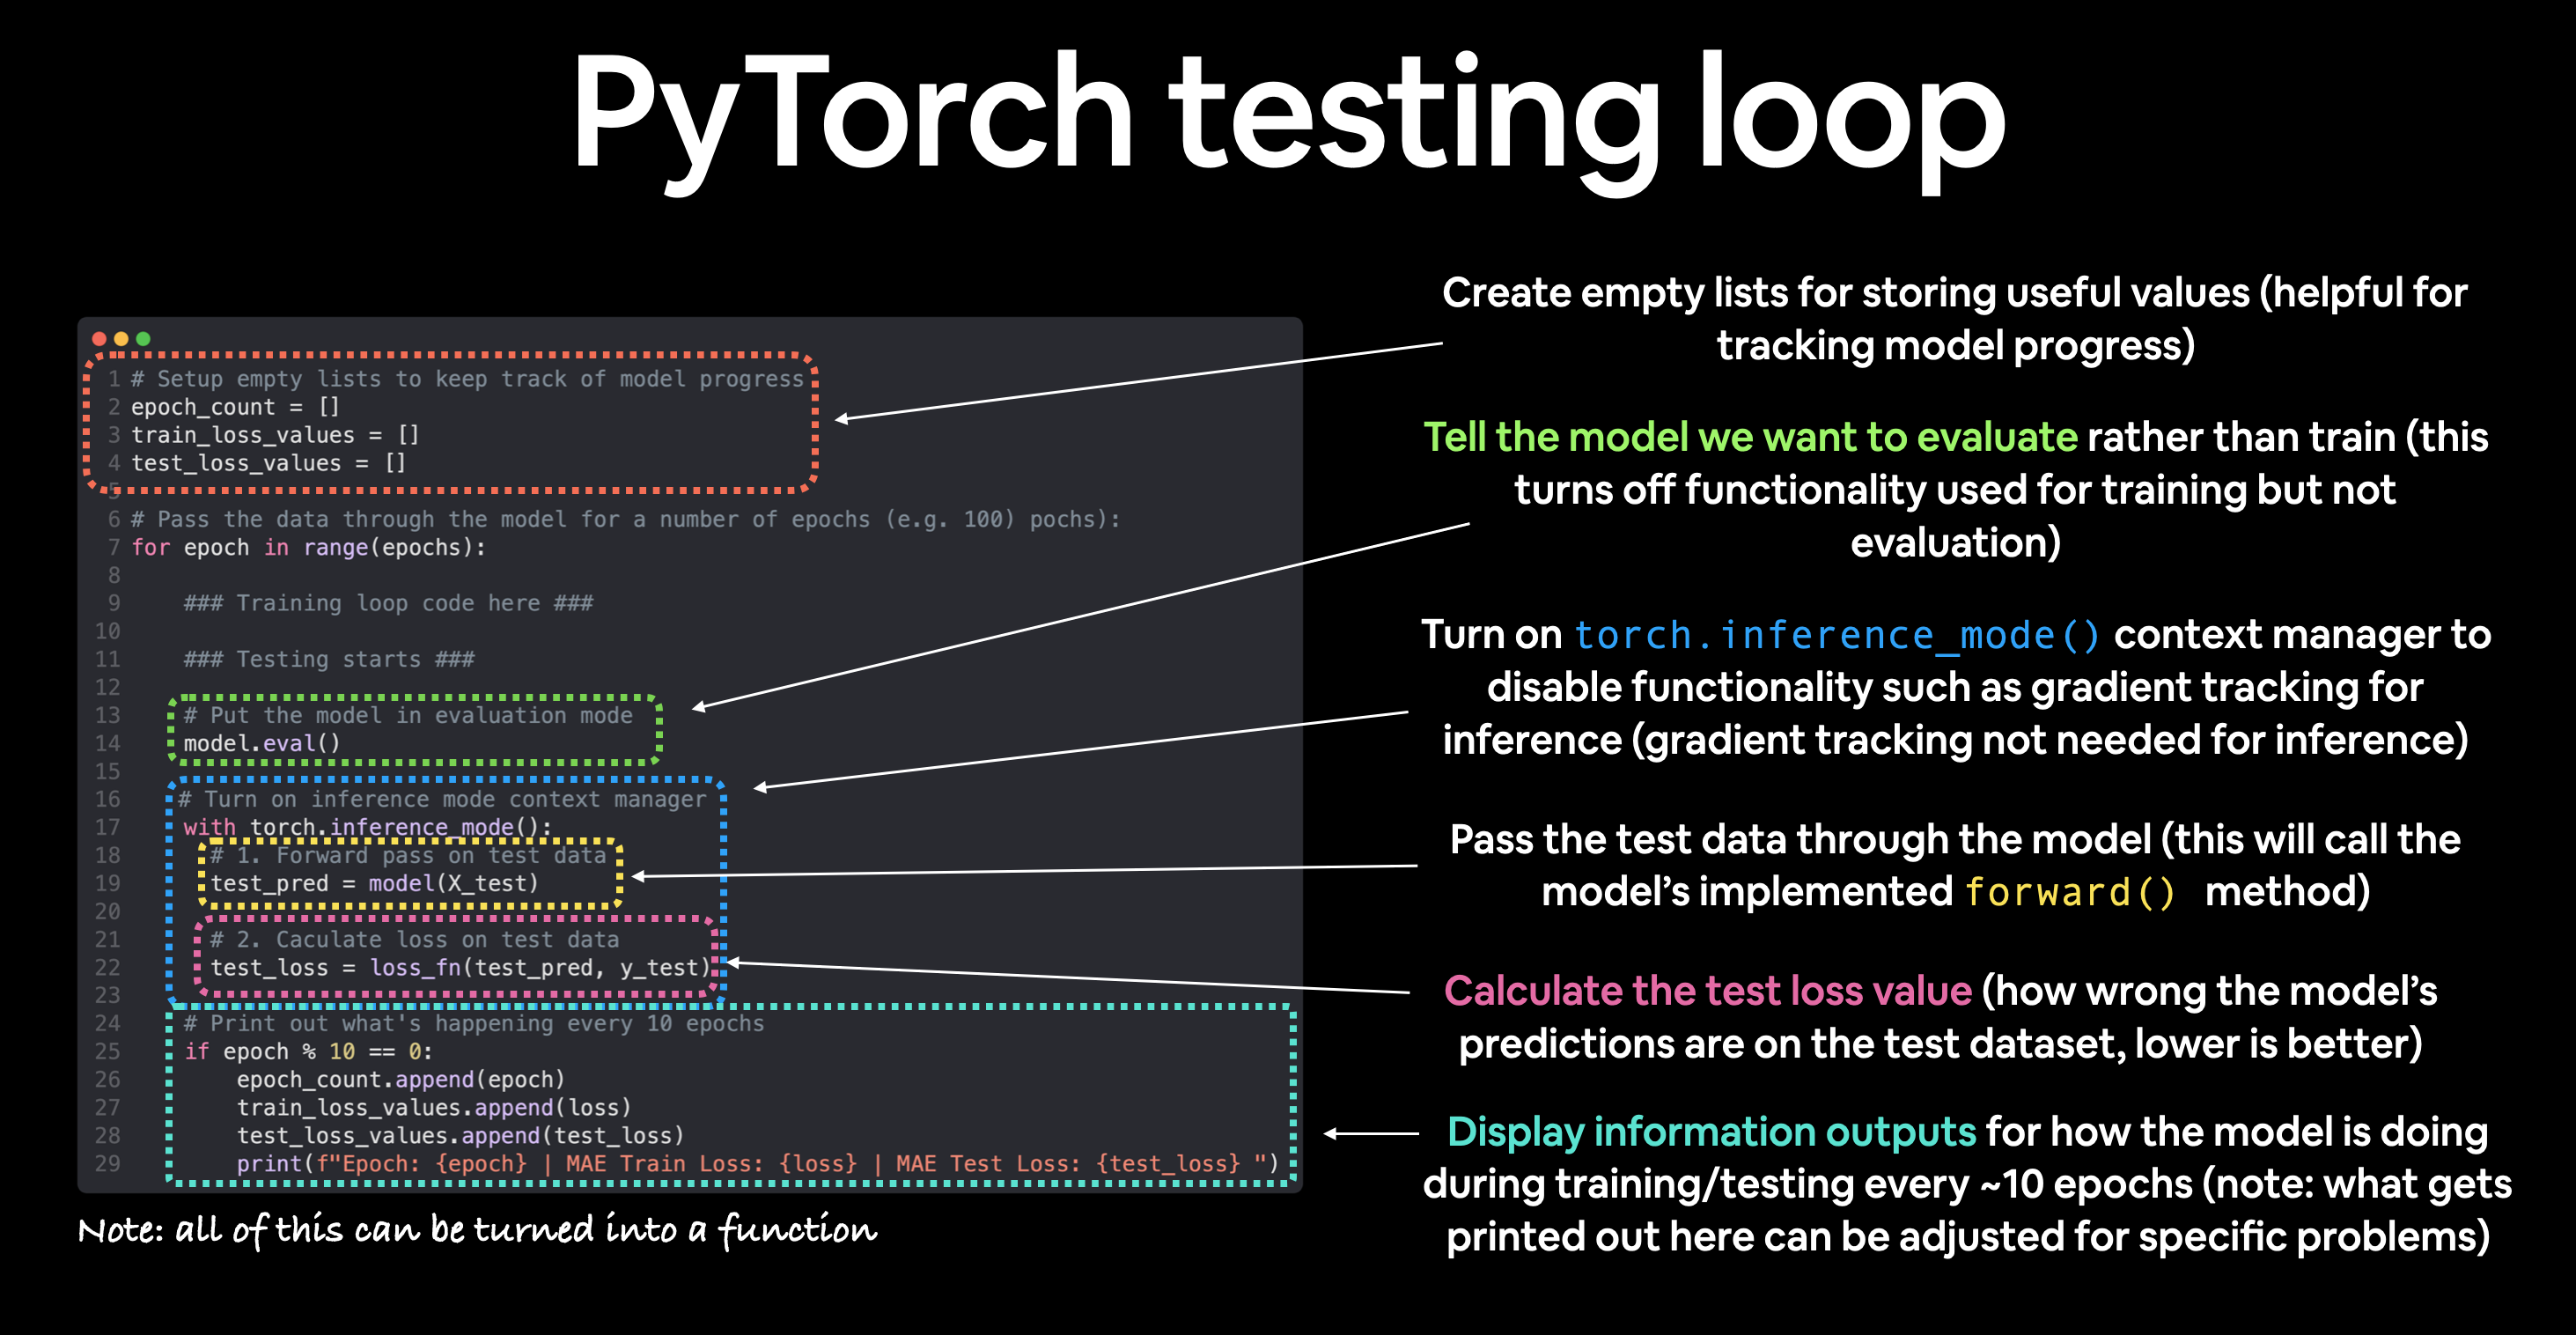

In [16]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values (for visuals)
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(x_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode(): # for better performance
      # 1. Forward pass on test data
      test_pred = model_0(x_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy()) # To be able to plot them make them numpy arrays
            test_loss_values.append(test_loss.detach().numpy()) # To be able to plot them make them numpy arrays
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 10 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 20 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 30 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 40 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 50 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 60 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 70 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 80 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 90 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 


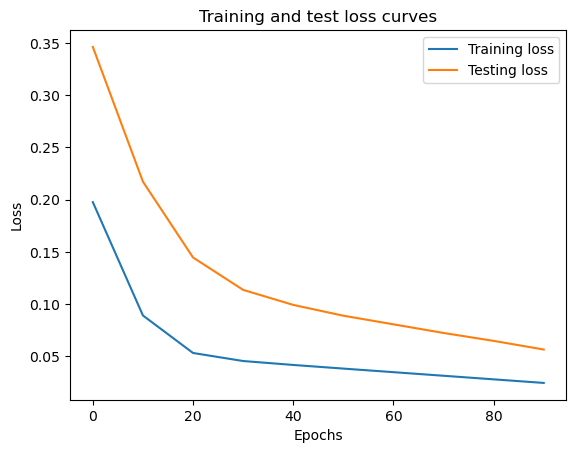

In [17]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Training loss")
plt.plot(epoch_count, test_loss_values, label="Testing loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

Our loss is going down with every epoch.

The loss curves show the loss going down over time. Remember, loss is the measure of how wrong your model is, so the lower the better.

## 4. Making predictions with a trained PyTorch model (inference)

In [18]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict({'weights': tensor([0.5954]), 'bias': tensor([0.3438])})

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


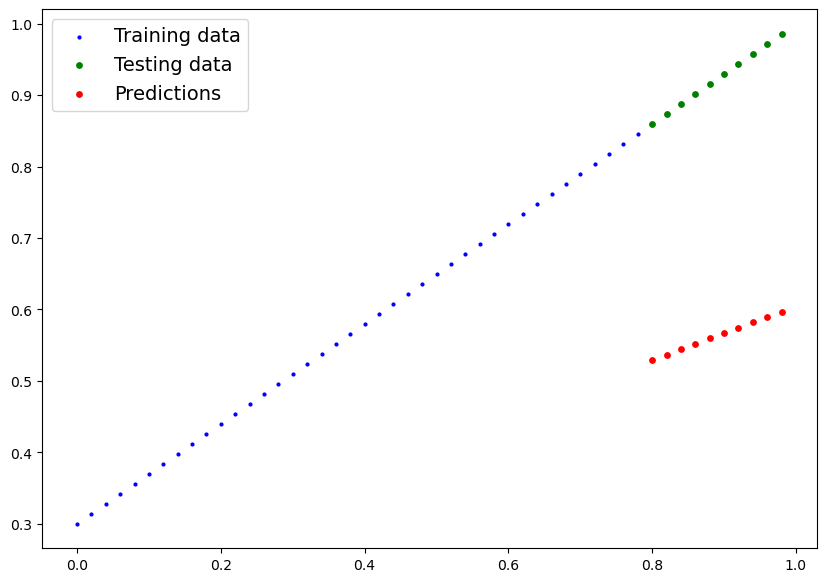

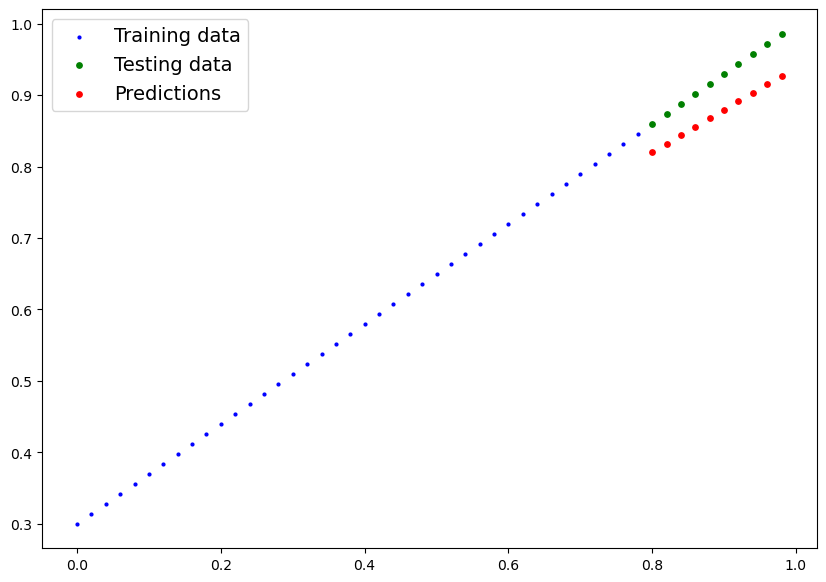

In [19]:
# Plotting the 2 to see the difference 
plot_predictions(predictions= y_preds)
with torch.inference_mode():
    y_preds_new = model_0(x_test)
    
plot_predictions(predictions= y_preds_new)

## 5. Saving and loading a PyTorch model

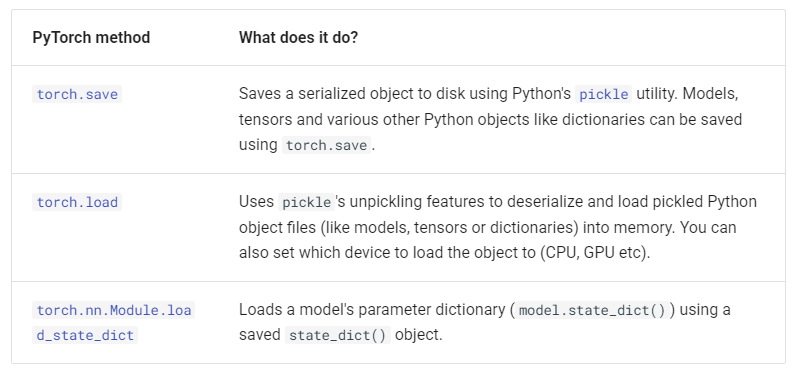\
**Note:** As stated in [Python's pickle documentation](https://docs.python.org/3/library/pickle.html), the pickle module is **not secure**. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.

### 1. **Saving** a PyTorch model's `state_dict()`
The [recommended way](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) for saving and loading a model for inference (making predictions) is by saving and loading a model's `state_dict()`.

Let's see how we can do that in a few steps:

1. We'll create a directory for saving models to, called `models`, using Python's `pathlib` module.
1. We'll create a *file path* to save the model to.
1. We'll call `torch.save(obj, f)` where `obj` is the target model's `state_dict()` and `f` is the *filename* of where to save the model.

In [20]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth" # pytorch models should be saved wirh extention "pt" or "pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_0.pth


### 2. **Loading** a saved PyTorch model's `state_dict()`
- Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.
- Because we only saved the model's `state_dict()` which is a dictionary of learned parameters and **not** the entire model, we first have to load the `state_dict()` with `torch.load()` and then pass that `state_dict()` to a new instance of our model (which is a subclass of nn.Module).

In [23]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [24]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5954])), ('bias', tensor([0.3438]))])

In [25]:
with torch.inference_mode():
    y_preds_loaded = loaded_model_0(x_test)
    
y_preds_new == y_preds_loaded

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

**[For more info about loading and saving data view pytorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models)**

## 6. Putting it all together

### Instead of defining parameters we can define **layers**
- Instead of defining the weight and bias parameters of our model manually using `nn.Parameter()`, we'll use `nn.Linear(in_features, out_features)` to do it for us.
- Where `in_features` is the number of **dimensions** your **input** data has and `out_features` is the number of **dimensions** you'd like it to be **output** to.

In our case, both of these are 1 since our data has 1 input feature (X) per label (y).

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always needed but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()